# Ensemble 모델을 활용한 인공지능 비트 트레이더 경진대회 베이스라인 코드

## 사용 모델 
* ARIMA
* Fbprophet
* Neuralprophet    
    
## 제출 결과
### Trade 전략 반영한 경우 
* 점수: 10087.040421259
* 매수 주식 개수: 20

### Trade 전략 반영하지 않은 경우
* 점수: 9256.3960056214
* 매수 주식 개수: 68    
    
### 비고 
* 모델 2개(Fbprophet,  ARIMA)를 Ensemble했을 때보다 성능이 많이 떨어짐

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


In [3]:
ls | grep ModuWay

ModuWay/


In [4]:
import os 
import random
import numpy as np 

#determinism seed
#random
SEED = 375

# random seed 
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

set_seeds(SEED)
print(SEED)

375


## 1. Library Install & Import

In [5]:
!pip install statsmodels==0.11.1
!pip install fbprophet
!pip install pmdarima

In [6]:
!pip install neuralprophet[live]==0.2.7

In [7]:
import numpy as np
import pandas as pd
import gc
import math
import os.path
import time
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
import warnings
import datetime
warnings.filterwarnings("ignore")

# 예측을 위해 사용되는 모델: ARIMA, NeuralProphet, fbrophet 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed 
from fbprophet import Prophet

## 2. 데이터 불러오기

### 1) read_csv

In [8]:
os.getcwd()

'/content/gdrive/My Drive'

In [9]:
data_path = os.getcwd()+ '/ModuWay/data'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

In [10]:
# 전체 dataframe 확인 
train_x_df.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000


In [11]:
# train set 컬럼값 특성 확인 
train_x_df.describe()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
count,1.015956e+07,1.015956e+07,1.015956e+07,1.015956e+07,1.015956e+07,1.015956e+07,1.015956e+07,1.015956e+07,1.015956e+07,1.015956e+07,1.015956e+07,1.015956e+07
mean,3.680500e+03,6.895000e+02,5.495925e+00,1.000988e+00,1.001753e+00,1.000196e+00,1.000980e+00,7.657862e+05,4.268907e+04,1.179676e+02,3.647911e+05,2.106137e+04
std,2.125226e+03,3.983716e+02,2.940005e+00,3.895120e-02,3.900216e-02,3.889973e-02,3.892255e-02,9.341042e+06,2.146420e+05,4.936206e+02,5.268894e+06,1.117901e+05
min,0.000000e+00,0.000000e+00,0.000000e+00,8.903663e-02,5.540227e-01,8.903663e-02,5.540227e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.840000e+03,3.447500e+02,4.000000e+00,9.871310e-01,9.878350e-01,9.863969e-01,9.871426e-01,5.047751e-02,3.126231e+01,7.715160e-02,5.671815e-03,1.066213e+01
50%,3.680500e+03,6.895000e+02,6.000000e+00,1.000000e+00,1.000556e+00,9.994500e-01,1.000000e+00,3.231240e+00,3.220208e+02,7.796185e-01,1.039115e+00,1.152704e+02
75%,5.521000e+03,1.034250e+03,8.000000e+00,1.012693e+00,1.013415e+00,1.011950e+00,1.012669e+00,4.258415e+04,1.254463e+04,5.641976e+01,9.016594e+03,4.863686e+03
max,7.361000e+03,1.379000e+03,9.000000e+00,2.066901e+00,4.451831e+00,2.066901e+00,2.066901e+00,7.398036e+09,3.705497e+07,6.257862e+04,7.340513e+09,2.320023e+07


In [12]:
# 특정 column명 확인
col_lst = test_x_df.columns.tolist() # 컬럼명을 리스트로 반환 
col_lst[-1] # 맨 마지막 컬럼명 확인: tb_quote_av

'tb_quote_av'

### 2) numpy arrary로 변환하기

In [13]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    print(feature_size, time_size, sample_size) # 3차원 배열의 구성: 
    sample_index = df_2d.sample_id.value_counts().index
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [14]:
print(train_x_df.shape)
train_x_df.head()

(10159560, 12)


,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000


In [15]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

10 1380 7362
10 120 7362
10 1380 529


In [16]:
valid_num = 50 # 50개의 validation 

In [17]:
# train 데이터 상단의 valid_num 샘플로 validation set를 구성하여 학습 및 추론
valid_x_df = train_x_df[train_x_df.sample_id < valid_num]
valid_y_df = train_y_df[train_y_df.sample_id < valid_num]

valid_x_array = df2d_to_array3d(valid_x_df)
valid_y_array = df2d_to_array3d(valid_y_df)
valid_pred_array = np.zeros([valid_num, 120])

10 1380 50
10 120 50


In [18]:
print(f'''
train_x_array {train_x_array.shape}
train_y_array {train_y_array.shape}
valid_x_array {valid_x_array.shape}
valid_y_array {valid_y_array.shape}
test_x_array {test_x_array.shape}
''')


train_x_array (7362, 1380, 10)
train_y_array (7362, 120, 10)
valid_x_array (50, 1380, 10)
valid_y_array (50, 120, 10)
test_x_array (529, 1380, 10)



### 3) 샘플 확인하기
특정 샘플 아이디를 설정하여, 10개의 컬럼들인 'coin_index', 'open', 'high', 'low', 'close', 'volume', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av'을 확인한다. 

In [19]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

In [20]:
idx = 1

In [21]:
train_x_df.columns

Index(['sample_id', 'time', 'coin_index', 'open', 'high', 'low', 'close',
       'volume', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av'],
      dtype='object')

In [22]:
train_x_df.shape

(10159560, 12)

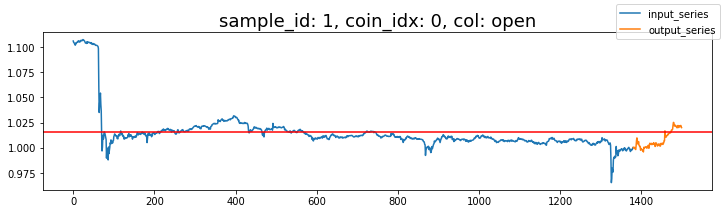

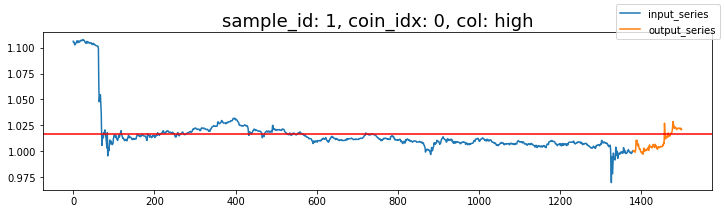

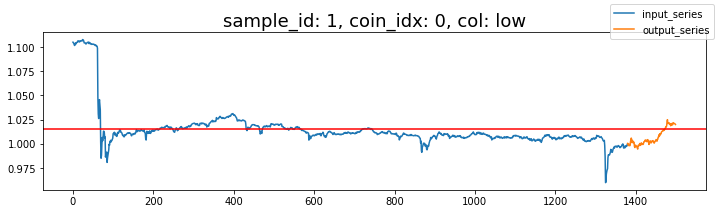

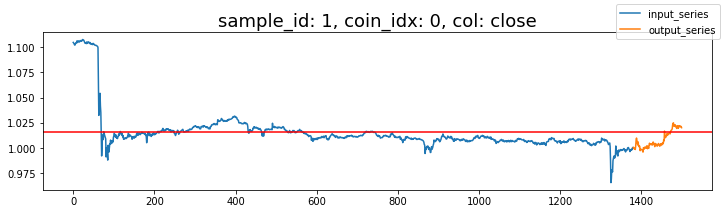

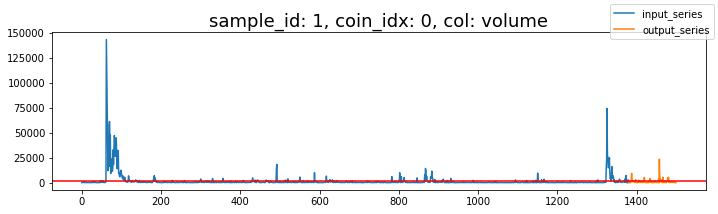

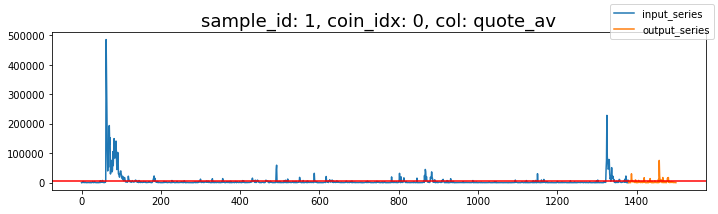

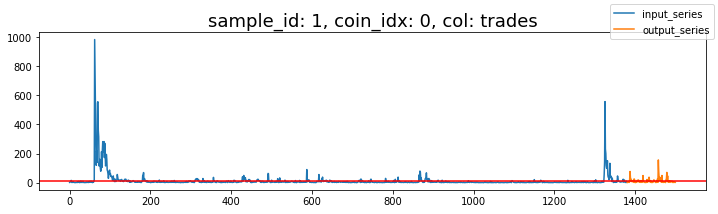

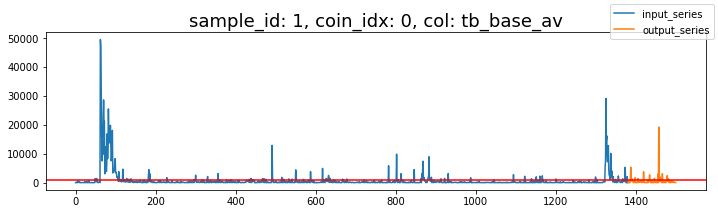

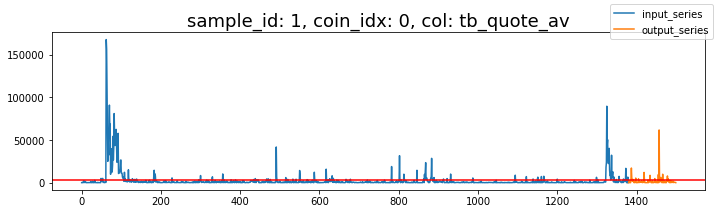

In [23]:
for col_idx_ in range(1, 10): # 10개의 컬럼 모두 보기 
    x_series_ = train_x_array[idx,:,col_idx_]
    y_series_ = train_y_array[idx,:,col_idx_]
    fig = plt.figure(figsize=(10, 3))
    coin_idx = str(int(train_x_array[idx,0,0])) # coin index를 확인용 변수
    plt.title('sample_id: '+str(idx)+', coin_idx: '+coin_idx+', col: '+train_x_df.columns[col_idx_+2], fontsize=18) # 3d array로 변환하면서 앞의 index 2개 제외 
    plt.plot(x_series_, label = 'input_series', )
    plt.plot(np.arange(len(x_series_), len(x_series_)+len(y_series_)),
             y_series_, label = 'output_series',)
    plt.axhline(train_x_array[idx,:,col_idx_].mean(), c = 'red') # 평균선
    fig.legend()
    fig.tight_layout()
    plt.show()
    # fig.savefig('Train_sampleID_{}.jpg'.format(idx)) # figure 저장 
    # time.sleep(1) # time delay

## 3. train data로 모델 학습하기

### 1st Model: ARIMA

#### 1) 입력 데이터 설정하기 - open가
* train dataframe에서 array로 변환해준 데이터에서 open가를 기준으로 입력데이터를 만든다. 

In [24]:
col_idx = 1 # open가
print(f'sample_id: {idx}, col_idx: {col_idx}, col_name: {train_x_df.columns[col_idx+2]}, coin_index: {train_x_array[idx,0,0]}')

x_series = train_x_array[idx,:,col_idx]
y_series = train_y_array[idx,:,col_idx]

sample_id: 1, col_idx: 1, col_name: open, coin_index: 0.0


In [25]:
x_series.tolist()[:5]

[1.10616934299469,
 1.1048787832260132,
 1.1044065952301023,
 1.1036827564239502,
 1.1026754379272459]

#### 2) Auto-arima 활용한 최적 모수 찾기
* auto-arima: p, d, q값을 적절하게 찾아준다.

In [26]:
from pmdarima.arima import auto_arima

best_model = auto_arima(x_series,
                                 seasonal=True, 
                                 stationary=False, 
                                 m=3,
                                 test='adf',
                                 stepwise=True,
                                 information_criterion='aic', 
                                 max_order=20,                
                                 start_p=3, start_q=3,
                                 max_p=10, max_d=3, max_q=10,                                     
                                 error_action='ignore')

P = best_model.order[0]
D = best_model.order[1]
Q = best_model.order[2]

s_P = best_model.seasonal_order[0]
s_D = best_model.seasonal_order[1]
s_Q = best_model.seasonal_order[2]
S = best_model.seasonal_order[3]

print("best model --> (P, D, Q):", best_model.order, " and  (P, D, Q, s):", best_model.seasonal_order)

best model --> (P, D, Q): (1, 0, 1)  and  (P, D, Q, s): (0, 0, 1, 3)


In [27]:
print(best_model.aic())

-12972.390824357175


#### 3) 모델 학습하기 

In [28]:
# ARIMA의 (p,d,q) 값은 최적화 되지않은 값 입니다.
model = ARIMA(x_series, order=(P,D,Q)) 
fit  = model.fit()

#### 4) 모델 예측 및 학습 결과 시각화

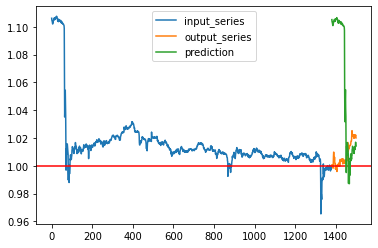

In [29]:
preds = fit.predict(1,120, typ='levels')

plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), preds, label = 'prediction')
plt.legend()
plt.show()

### 2nd Model: Fbprophet

#### 1) x_series를 분단위 날짜 데이터로 변환하기
* train dataframe에서 array로 변환해준 데이터에서 open가를 기준으로 입력데이터를 만든다. 
* datetime 라이브러리를 활용해서 0~1380값을 날짜 형식(년-월-일-시-분-초)으로 매핑해준다.  

In [30]:
# start time에 일자는 중요하지 않다. 아무 날짜 넣어주면 된다. 분 데이터로 표현을 바꿔주기 위함. 
start_time = '2021-01-31 00:00:00'
start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
start_dt

datetime.datetime(2021, 1, 31, 0, 0)

In [31]:
x_df = pd.DataFrame()
x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
x_df['y'] = x_series.tolist()

In [32]:
x_df.head()

,ds,y
0,2021-01-31 00:01:00,1.106169
1,2021-01-31 00:02:00,1.104879
2,2021-01-31 00:03:00,1.104407
3,2021-01-31 00:04:00,1.103683
4,2021-01-31 00:05:00,1.102675


In [33]:
x_df.shape

(1380, 2)

#### 2) 모델 구현하기

In [34]:
# 파라미터 조정
scale = 0.01 # changepoint를 많이 잡도록 
width = 0.95
point_range = 1

In [35]:
prophet = Prophet( 
                  yearly_seasonality=False,
                  weekly_seasonality=False, 
                  daily_seasonality=True,
                  changepoint_prior_scale=scale, 
                  interval_width=width, 
                  changepoint_range=point_range,
                  # growth='logistic', # growth 추가
                  growth='linear',
                  seasonality_mode='multiplicative', # seasonality 추가 
                  seasonality_prior_scale=50.0 # seasonality scale 추가 
                  ) 
prophet.add_seasonality(name='twent_minutes', period=100, fourier_order=3)
prophet.add_seasonality(name='twent_minutes', period=20, fourier_order=3)
prophet.add_seasonality(name='ten_minutes', period=10, fourier_order=3)
prophet.add_seasonality(name='five_minutes', period=5, fourier_order=3)

#### 3) 모델 학습하기 

In [36]:
prophet.fit(x_df)

#### 4) 모델 예측 및 학습 결과 시각화

In [37]:
# 10분 테스트 데이터를 예측합니다.
future_data = prophet.make_future_dataframe(periods=100, freq='min')
forecast_data = prophet.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
1475,2021-02-01 00:36:00,1.017226,1.001134,1.032686
1476,2021-02-01 00:37:00,1.017784,1.002156,1.034472
1477,2021-02-01 00:38:00,1.018350,1.001403,1.034794
1478,2021-02-01 00:39:00,1.018924,1.002890,1.034100
1479,2021-02-01 00:40:00,1.019507,1.003053,1.036620


120 120 120


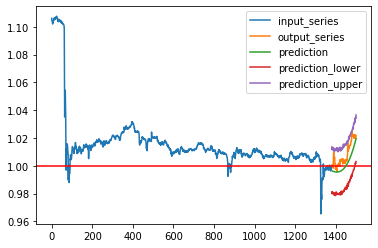

In [38]:
pred_y = forecast_data.yhat.values[-120:]
pred_y_lower = forecast_data.yhat_lower.values[-120:]
pred_y_upper = forecast_data.yhat_upper.values[-120:]

print(len(pred_y), len(pred_y_lower), len(pred_y_upper))

plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), pred_y, label = 'prediction')
plt.plot(np.arange(1380, 1380+120), pred_y_lower, label = 'prediction_lower')
plt.plot(np.arange(1380, 1380+120), pred_y_upper, label = 'prediction_upper')
plt.legend()
plt.show()

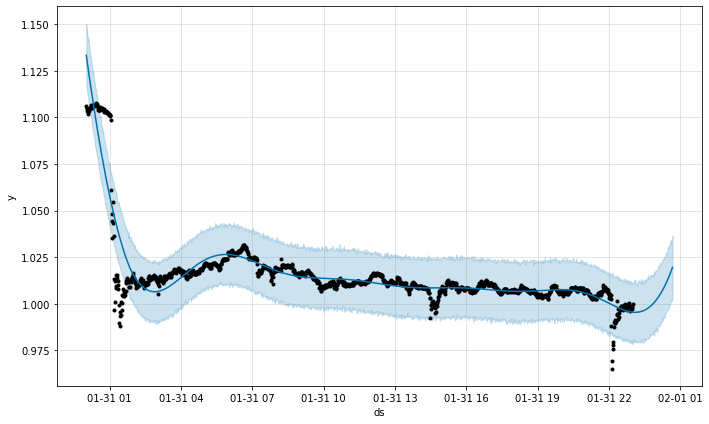

In [39]:
# 만들어진 데이터를 확인합니다.
fig1 = prophet.plot(forecast_data)

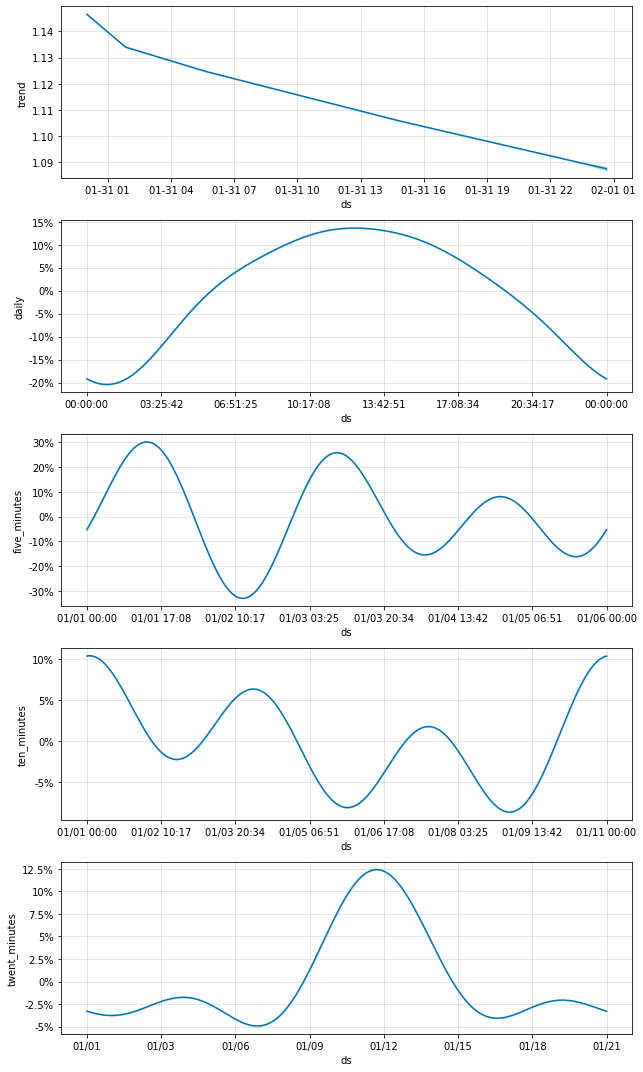

In [40]:
# 데이터의 추세를 확인합니다.
fig2 = prophet.plot_components(forecast_data)

### 3rd Model: Neuralprophet

#### 1) x_series를 일단위 날짜 데이터로 변환하기
* train dataframe에서 array로 변환해준 데이터에서 open가를 기준으로 입력데이터를 만든다. 
* datetime 라이브러리를 활용해서 0~1380값을 날짜 형식(년-월-일)으로 매핑해준다. 

> 왜 Fbprophet과 다르게 분단위로 해주지 않았는지? Neuralprohet에는 add_seasonality 메서드가 없어서 따로 계절성을 원하는 주기로 줄 수 없기 때문이다. 

In [41]:
x_series.tolist()[:5]

[1.10616934299469,
 1.1048787832260132,
 1.1044065952301023,
 1.1036827564239502,
 1.1026754379272459]

In [42]:
start_time = '2018-01-31'
start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d')

x_df = pd.DataFrame()
x_df['ds'] = [start_dt + datetime.timedelta(days = time_day) for time_day in np.arange(1, x_series.shape[0]+1).tolist()]
x_df['y'] = x_series.tolist()

In [43]:
x_df.head()

,ds,y
0,2018-02-01,1.106169
1,2018-02-02,1.104879
2,2018-02-03,1.104407
3,2018-02-04,1.103683
4,2018-02-05,1.102675


In [44]:
x_df.shape

(1380, 2)

#### 2) 모델 구현하기

In [45]:
# 파라미터 조정
scale = 0.01 # changepoint를 많이 잡도록 
width = 0.95
point_range = 1

In [46]:
prophet = Prophet( 
                  yearly_seasonality=False,
                  weekly_seasonality=False, 
                  daily_seasonality=True,
                  changepoint_prior_scale=scale, 
                  interval_width=width, 
                  changepoint_range=point_range,
                  # growth='logistic', # growth 추가
                  growth='linear',
                  seasonality_mode='multiplicative', # seasonality 추가 
                  seasonality_prior_scale=50.0 # seasonality scale 추가 
                  ) 
prophet.add_seasonality(name='twent_minutes', period=100, fourier_order=3)
prophet.add_seasonality(name='twent_minutes', period=20, fourier_order=3)
prophet.add_seasonality(name='ten_minutes', period=10, fourier_order=3)
prophet.add_seasonality(name='five_minutes', period=5, fourier_order=3)

#### 3) 모델 학습하기 
- n_changepoints = 100, 65 buying, total 9742.418210989932
- n_changepoints = 150, 83 buying, total 6651.209203152537
- n_changepoints = 200, 90 buying, total 7960.144600296403
- n_changepoints = 125, 72 buying, total 8593.15439366368
- n_changepoints = 110, 69 buying, total 11056.573616988802
- n_changepoints = 105, 70 buying, total 9123.211631741
- n_changepoints = 95,  60 buying, total 7499.036343409599
- n_changepoints = 90,  64 buying, total 7906.222956483016
- n_changepoints = 120, 73 buying, total 8204.822700670702
- n_changepoints = 115, 82 buying, total 7737.994020448561

In [47]:
# 파라미터 조정

# # prophet
# scale = 0.01
# width = 0.95
# point_range = 1
seasonality_prior_scale = 50.0

## neural prophet
epochs = 10
# batch_size = 64
learning_rate = 0.05


# AR net 
n_forecasts = 120 # 예측 기간의 크기  # future_periods랑 같아야한다. 
# num_hidden_layers = 64 # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = 110 # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03

#n_lags = 5  # >error : lambda delay가 없다 

In [48]:
nprophet = NeuralProphet(yearly_seasonality=False, 
            weekly_seasonality=True, daily_seasonality=True,
            learning_rate=learning_rate, 
            changepoints_range=changepoints_range, n_forecasts=n_forecasts,
            ar_sparsity=ar_sparsity, n_changepoints=n_changepoints, 
            growth='linear', seasonality_mode='multiplicative', 
            trend_reg=trend_reg
        )

INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.


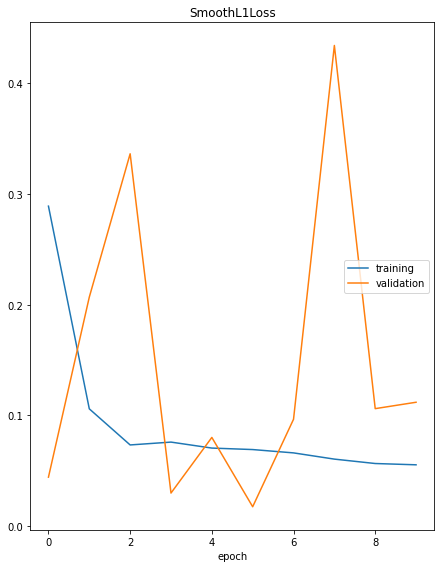

Epoch[10/10]: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s, SmoothL1Loss=0.0554, MAE=0.00868, RegLoss=0.000729, MAE_val=0.0185, SmoothL1Loss_val=0.112]


,SmoothL1Loss,MAE,RegLoss,SmoothL1Loss_val,MAE_val
0,0.289147,0.030676,0.000377,0.044254,0.012857
1,0.105991,0.014058,0.000409,0.206978,0.025897
2,0.073370,0.010183,0.000390,0.336473,0.037241
3,0.075944,0.010927,0.000429,0.029892,0.007881
4,0.070540,0.010530,0.000488,0.080162,0.018013
5,0.069202,0.010526,0.000582,0.017532,0.006928
6,0.066189,0.010705,0.000642,0.096552,0.019728
7,0.060563,0.009697,0.000711,0.434360,0.041085
8,0.056591,0.008944,0.000728,0.106175,0.017819
9,0.055422,0.008677,0.000729,0.111952,0.018496


In [49]:
nprophet.fit(x_df, plot_live_loss=True, epochs=epochs, freq='d', validate_each_epoch=True, valid_p=0.1)
# nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts) # 최종 결과만 보고 싶으면 주석 풀기

#### 4) 모델 예측 및 학습 결과 시각화

In [50]:
# 120분 테스트 데이터를 예측합니다.
future_data = nprophet.make_future_dataframe(x_df, periods=300, n_historic_predictions=300)
forecast_data = nprophet.predict(future_data)
forecast_data[['ds', 'y', 'yhat1', 'trend']].tail(5)
forecast_data.head()

,ds,y,yhat1,residual1,trend,season_weekly,season_daily
0,2021-01-16,1.006579,1.008213,0.001634,0.969518,-0.000880,-2.809544
1,2021-01-17,1.007397,1.008478,0.001081,0.969547,-0.024044,-2.809544
2,2021-01-18,1.007271,1.008150,0.000879,0.969577,-0.004065,-2.809544
3,2021-01-19,1.007271,1.008494,0.001223,0.969606,-0.033153,-2.809544
4,2021-01-20,1.006516,1.007754,0.001238,0.969636,0.017058,-2.809544


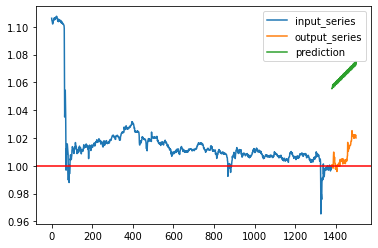

In [51]:
y = forecast_data.y.values[-120:]
pred_y = forecast_data.yhat1.values[-120:]
trend = forecast_data.trend.values[-120:]
residual = forecast_data.residual1.values[-120:]

plot_series(x_series, y_series)
# plt.plot(np.arange(1380, 1380+120), y, label = 'y')
plt.plot(np.arange(1380, 1380+120), pred_y, label = 'prediction')
# plt.plot(np.arange(1380, 1380+120), trend, label = 'trend')
# plt.plot(np.arange(1380, 1380+120), residual, label = 'residual')
plt.legend()
plt.show()

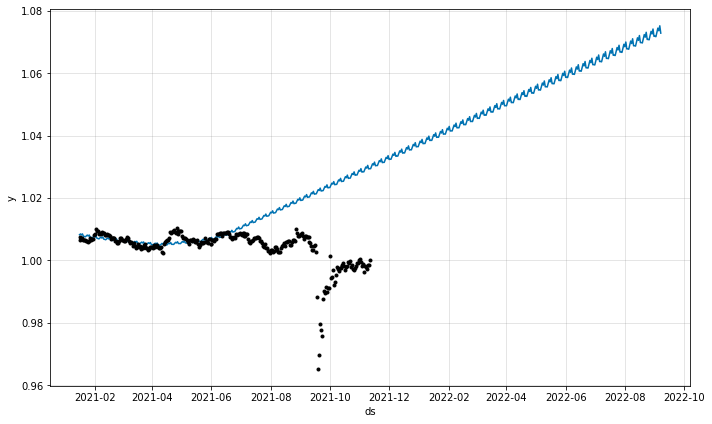

In [52]:
# 만들어진 데이터를 확인합니다.
fig1 = nprophet.plot(forecast_data)

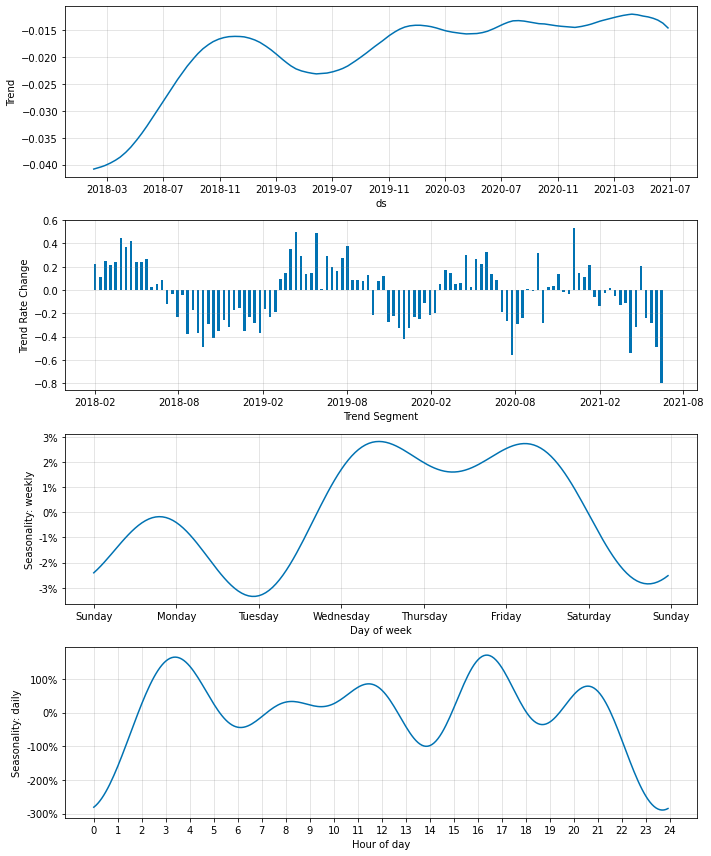

In [53]:
fig_param = nprophet.plot_parameters()

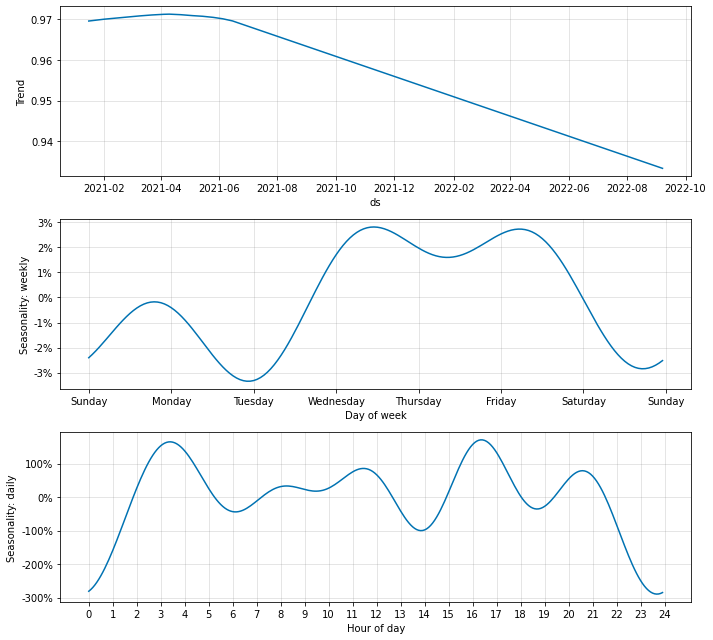

In [54]:
# 데이터의 추세를 확인합니다.
fig2 = nprophet.plot_components(forecast_data)

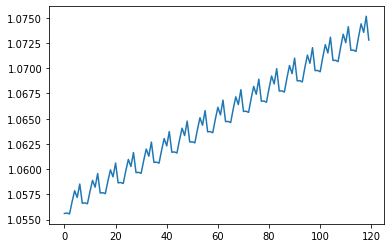

In [55]:
plt.plot(pred_y)

## valid data로 모델 학습 & Trading하기

### 1st Model: ARIMA

#### 1) for문 활용한 전체 학습 및 예측
* 여러 개의 샘플에 대해 수행하기 위해 for loop를 사용한다. 
* dataframe에서 array로 변환해준 데이터에서 open가를 기준으로 입력데이터를 만든다. 
* Auto-arima 활용한 최적 모수 찾기
* 모델 학습 & 예측하기

In [56]:
col_idx = 1 # open가
col_idx

1

In [ ]:
for idx in tqdm(range(valid_x_array.shape[0])):
    try:
        try:
            x_series = valid_x_array[idx,:,col_idx]

            best_model = auto_arima(x_series,
                                 seasonal=True, 
                                 stationary=False, 
                                 m=3,
                                 test='adf',
                                 stepwise=True,
                                 information_criterion='aic', 
                                 max_order=20,                
                                 start_p=3, start_q=3,
                                 max_p=10, max_d=3, max_q=10,                                     
                                 error_action='ignore')
            print(" (P, D, Q):", best_model.order, end="")
            print(" , aic: ", best_model.aic())

            P = best_model.order[0]
            D = best_model.order[1]
            Q = best_model.order[2]

            model = ARIMA(x_series, order=(P,D,Q))
            fit  = model.fit()
            preds = fit.predict(1,120, typ='levels')
            arima_valid_pred_array[idx,:] = preds# - (preds[0]-x_series[-1])
        except:
            x_series = valid_x_array[idx,:,col_idx]
            print(" (P, D, Q):", P+1, D, Q)

            model = ARIMA(x_series, order=(P+1,D,Q))
            fit  = model.fit()
            preds = fit.predict(1,120, typ='levels')
            arima_valid_pred_array[idx,:] = preds
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

  0%|          | 0/50 [00:00<?, ?it/s]

 (P, D, Q): (0, 1, 1) , aic:  -16089.491821437574
 (P, D, Q): 1 1 1


  2%|▏         | 1/50 [00:26<21:39, 26.51s/it]

0  샘플은 수렴하지 않습니다.
 (P, D, Q): (1, 0, 1) , aic:  -12972.390824357175
 (P, D, Q): 2 0 1


  4%|▍         | 2/50 [01:50<48:23, 60.50s/it]

1  샘플은 수렴하지 않습니다.
 (P, D, Q): (2, 1, 2) , aic:  -14259.913125804487
 (P, D, Q): 3 1 2


  6%|▌         | 3/50 [02:16<34:50, 44.49s/it]

2  샘플은 수렴하지 않습니다.
 (P, D, Q): (0, 1, 0) , aic:  -15482.065131052668
 (P, D, Q): 1 1 0


  8%|▊         | 4/50 [02:31<25:20, 33.05s/it]

3  샘플은 수렴하지 않습니다.
 (P, D, Q): (0, 1, 0) , aic:  -14806.719189307214
 (P, D, Q): 1 1 0


 10%|█         | 5/50 [02:45<19:39, 26.22s/it]

4  샘플은 수렴하지 않습니다.
 (P, D, Q): (0, 1, 1) , aic:  -11998.036160011281
 (P, D, Q): 1 1 1


 12%|█▏        | 6/50 [03:02<16:49, 22.95s/it]

5  샘플은 수렴하지 않습니다.
 (P, D, Q): (1, 1, 1) , aic:  -14896.436526328634
 (P, D, Q): 2 1 1


 14%|█▍        | 7/50 [03:33<18:15, 25.47s/it]

6  샘플은 수렴하지 않습니다.
 (P, D, Q): (1, 1, 0) , aic:  -17368.714895442186
 (P, D, Q): 2 1 0


 16%|█▌        | 8/50 [03:57<17:37, 25.18s/it]

7  샘플은 수렴하지 않습니다.
 (P, D, Q): (1, 1, 0) , aic:  -15821.15901967659
 (P, D, Q): 2 1 0


 18%|█▊        | 9/50 [04:26<18:00, 26.34s/it]

8  샘플은 수렴하지 않습니다.
 (P, D, Q): (1, 1, 0) , aic:  -13528.570450127496
 (P, D, Q): 2 1 0


 20%|██        | 10/50 [04:45<15:56, 23.91s/it]

9  샘플은 수렴하지 않습니다.
 (P, D, Q): (2, 1, 2) , aic:  -13777.920090338954
 (P, D, Q): 3 1 2


 22%|██▏       | 11/50 [05:05<14:47, 22.75s/it]

10  샘플은 수렴하지 않습니다.
 (P, D, Q): (0, 1, 0) , aic:  -15458.663617018094
 (P, D, Q): 1 1 0


 24%|██▍       | 12/50 [05:20<13:03, 20.62s/it]

11  샘플은 수렴하지 않습니다.
 (P, D, Q): (2, 0, 0) , aic:  -13653.367168885612
 (P, D, Q): 3 0 0


 26%|██▌       | 13/50 [06:54<26:15, 42.59s/it]

12  샘플은 수렴하지 않습니다.
 (P, D, Q): (1, 1, 0) , aic:  -15541.192350360265
 (P, D, Q): 2 1 0


 28%|██▊       | 14/50 [07:50<28:01, 46.72s/it]

13  샘플은 수렴하지 않습니다.
 (P, D, Q): (0, 1, 1) , aic:  -11121.468825102196
 (P, D, Q): 1 1 1


 30%|███       | 15/50 [08:05<21:38, 37.10s/it]

14  샘플은 수렴하지 않습니다.
 (P, D, Q): (0, 1, 0) , aic:  -13992.19582591346
 (P, D, Q): 1 1 0


 32%|███▏      | 16/50 [08:24<18:00, 31.78s/it]

15  샘플은 수렴하지 않습니다.
 (P, D, Q): (0, 1, 0) , aic:  -17923.063078879466
 (P, D, Q): 1 1 0


 34%|███▍      | 17/50 [08:36<14:08, 25.71s/it]

16  샘플은 수렴하지 않습니다.
 (P, D, Q): (0, 1, 1) , aic:  -16128.861199522049
 (P, D, Q): 1 1 1


 36%|███▌      | 18/50 [08:58<13:07, 24.62s/it]

17  샘플은 수렴하지 않습니다.
 (P, D, Q): (0, 1, 0) , aic:  -14071.452247661713
 (P, D, Q): 1 1 0


 38%|███▊      | 19/50 [09:13<11:18, 21.90s/it]

18  샘플은 수렴하지 않습니다.
 (P, D, Q): (0, 1, 0) , aic:  -15632.280674884969
 (P, D, Q): 1 1 0


 40%|████      | 20/50 [09:45<12:25, 24.87s/it]

19  샘플은 수렴하지 않습니다.
 (P, D, Q): (1, 0, 2) , aic:  -15301.715964417092
 (P, D, Q): 2 0 2


 42%|████▏     | 21/50 [10:48<17:35, 36.40s/it]

20  샘플은 수렴하지 않습니다.
 (P, D, Q): (0, 1, 2) , aic:  -13764.861861399924
 (P, D, Q): 1 1 2


 44%|████▍     | 22/50 [11:17<15:50, 33.93s/it]

21  샘플은 수렴하지 않습니다.
 (P, D, Q): (0, 1, 0) , aic:  -13480.11171149183
 (P, D, Q): 1 1 0


 46%|████▌     | 23/50 [11:26<11:59, 26.64s/it]

22  샘플은 수렴하지 않습니다.
 (P, D, Q): (0, 1, 1) , aic:  -13351.401508252284
 (P, D, Q): 1 1 1


 48%|████▊     | 24/50 [11:57<12:03, 27.81s/it]

23  샘플은 수렴하지 않습니다.
 (P, D, Q): (1, 1, 1) , aic:  -16550.239682708532
 (P, D, Q): 2 1 1


 50%|█████     | 25/50 [12:23<11:22, 27.31s/it]

24  샘플은 수렴하지 않습니다.
 (P, D, Q): (0, 1, 2) , aic:  -16318.16095086
 (P, D, Q): 1 1 2


 52%|█████▏    | 26/50 [13:05<12:42, 31.78s/it]

25  샘플은 수렴하지 않습니다.
 (P, D, Q): (0, 1, 0) , aic:  -14968.40852299744
 (P, D, Q): 1 1 0


 54%|█████▍    | 27/50 [13:21<10:24, 27.16s/it]

26  샘플은 수렴하지 않습니다.
 (P, D, Q): (0, 1, 0) , aic:  -12110.16776504747
 (P, D, Q): 1 1 0


 56%|█████▌    | 28/50 [13:32<08:08, 22.23s/it]

27  샘플은 수렴하지 않습니다.
 (P, D, Q): (1, 1, 0) , aic:  -16356.232444123947
 (P, D, Q): 2 1 0


 58%|█████▊    | 29/50 [14:10<09:25, 26.95s/it]

28  샘플은 수렴하지 않습니다.
 (P, D, Q): (0, 1, 2) , aic:  -14125.646062683281
 (P, D, Q): 1 1 2


 60%|██████    | 30/50 [14:42<09:28, 28.41s/it]

29  샘플은 수렴하지 않습니다.
 (P, D, Q): (0, 1, 0) , aic:  -14560.118849928753
 (P, D, Q): 1 1 0


 62%|██████▏   | 31/50 [14:54<07:28, 23.63s/it]

30  샘플은 수렴하지 않습니다.
 (P, D, Q): (2, 1, 2) , aic:  -15763.341858564345
 (P, D, Q): 3 1 2


 64%|██████▍   | 32/50 [15:23<07:34, 25.23s/it]

31  샘플은 수렴하지 않습니다.
 (P, D, Q): (1, 0, 2) , aic:  -15618.406300331011
 (P, D, Q): 2 0 2


 66%|██████▌   | 33/50 [16:06<08:38, 30.48s/it]

32  샘플은 수렴하지 않습니다.
 (P, D, Q): (2, 0, 0) , aic:  -15426.217941754865
 (P, D, Q): 3 0 0


 68%|██████▊   | 34/50 [17:21<11:38, 43.66s/it]

33  샘플은 수렴하지 않습니다.
 (P, D, Q): (0, 1, 0) , aic:  -16080.301698438703
 (P, D, Q): 1 1 0


 70%|███████   | 35/50 [17:33<08:36, 34.44s/it]

34  샘플은 수렴하지 않습니다.
 (P, D, Q): (0, 1, 0) , aic:  -11830.29651979294
 (P, D, Q): 1 1 0


 72%|███████▏  | 36/50 [17:53<07:01, 30.10s/it]

35  샘플은 수렴하지 않습니다.
 (P, D, Q): (0, 1, 0) , aic:  -16303.98777138654
 (P, D, Q): 1 1 0


 74%|███████▍  | 37/50 [18:11<05:40, 26.20s/it]

36  샘플은 수렴하지 않습니다.
 (P, D, Q): (0, 1, 0) , aic:  -12858.248947658554
 (P, D, Q): 1 1 0


 76%|███████▌  | 38/50 [18:19<04:12, 21.02s/it]

37  샘플은 수렴하지 않습니다.
 (P, D, Q): (1, 1, 0) , aic:  -15746.829834815771
 (P, D, Q): 2 1 0


 78%|███████▊  | 39/50 [18:43<03:58, 21.66s/it]

38  샘플은 수렴하지 않습니다.


#### 2) buy_quantity, sell_time 구하기(함수 포함)
* array_to_submission 함수 구현

In [ ]:
def array_to_submission(x_array, pred_array):
    # 입력 x_arrry와 출력 pred_arry를 통해서 
    # buy_quantitiy와 sell_time을 결정
    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 0.1
    
    buy_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])

    buy_price = np.array(buy_price)

    # 115% 이상 상승한하고 예측한 sample에 대해서만 100% 매수
    submission.loc[:, 'buy_quantity'] = (buy_price > 1.15) * 1

    # 모델이 예측값 중 최대 값에 해당하는 시간에 매도
    submission['sell_time'] = np.argmax(pred_array, axis = 1)
    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    return submission

In [ ]:
arima_valid_submission = array_to_submission(valid_x_array, arima_valid_pred_array)
arima_valid_submission.buy_quantity.value_counts()

#### 3) 투자 후 금액 계산하기(함수 포함)

In [ ]:
def df2d_to_answer(df_2d):
    # valid_y_df로부터
    # open 가격 정보가 포함된
    # [샘플 수, 120분] 크기의 
    # 2차원 array를 반환하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    sample_index = list(sample_index)
    return array_2d, sample_index


def COIN(y_df, submission, df2d_to_answer = df2d_to_answer):
    # 2차원 데이터프레임에서 open 시점 데이터만 추출하여 array로 복원
    # sample_id정보를 index에 저장
    y_array, index = df2d_to_answer(y_df)
    
    # index 기준으로 submission을 다시 선택
    submission = submission.set_index(submission.columns[0])
    submission = submission.iloc[index, :]    
    
    # 초기 투자 비용은 10000 달러
    total_momey      = 10000 # dolors
    total_momey_list = []
    
    # 가장 처음 sample_id값
    start_index = submission.index[0]
    for row_idx in submission.index:
        sell_time  = submission.loc[row_idx, 'sell_time']
        buy_price  = y_array[row_idx - start_index, 0]
        sell_price = y_array[row_idx - start_index, sell_time]
        buy_quantity = submission.loc[row_idx, 'buy_quantity'] * total_momey
        residual = total_momey - buy_quantity
        ratio = sell_price / buy_price
        total_momey = buy_quantity * ratio * 0.9995 * 0.9995 + residual        
        total_momey_list.append(total_momey)
        
    return total_momey, total_momey_list

In [ ]:
total_momey, total_momey_list = COIN(valid_y_df,
                                     arima_valid_submission)
# 투자 후 금액
print(total_momey)

In [ ]:
# 투자 히스토리
plt.plot(total_momey_list)
plt.title("history")
plt.show()

### 2nd Model: Fbprophet

#### 1) for문 활용한 전체 학습 및 예측
* 여러 개의 샘플에 대해 수행하기 위해 for loop를 사용한다. 
* dataframe에서 array로 변환해준 데이터에서 open가를 기준으로 입력데이터를 만든다. 
* datetime 라이브러리를 활용해서 0~1380값을 날짜 형식(년-월-일-시-분-초)으로 매핑해준다.  
* 모델 학습 & 예측하기

In [ ]:
# start time에 일자는 중요하지 않다. 아무 날짜 넣어주면 된다. 분 데이터로 표현을 바꿔주기 위함. 
start_time = '2021-01-31 00:00:00'
start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
start_dt

In [ ]:
# 1시간 15분 소요
for idx in tqdm(range(valid_x_array.shape[0])):
    try:
        x_series = valid_x_array[idx,:,1]

        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()

        prophet = Prophet( 
                          yearly_seasonality=False,
                          weekly_seasonality=False, 
                          daily_seasonality=True,
                          changepoint_prior_scale=scale, 
                          interval_width=width, 
                          changepoint_range=point_range,
                          # growth='logistic', # growth 추가
                          growth='linear',
                          seasonality_mode='multiplicative', # seasonality 추가 
                          seasonality_prior_scale=50.0 # seasonality scale 추가 
                          ) 
        prophet.add_seasonality(name='twent_minutes', period=100, fourier_order=3)
        prophet.add_seasonality(name='twent_minutes', period=20, fourier_order=3)
        prophet.add_seasonality(name='ten_minutes', period=10, fourier_order=3)
        prophet.add_seasonality(name='five_minutes', period=5, fourier_order=3)

        prophet.fit(x_df)
        
        # 120분 테스트 데이터를 예측합니다.
        future_data = prophet.make_future_dataframe(periods=120, freq='min')
        forecast_data = prophet.predict(future_data)
        forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

        pred_y = forecast_data.yhat.values[-120:]
        pred_y_lower = forecast_data.yhat_lower.values[-120:]
        pred_y_upper = forecast_data.yhat_upper.values[-120:]

        fb_valid_pred_array[idx,:] = pred_y
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

#### 2) buy_quantity, sell_time 구하기

In [ ]:
fb_valid_submission = array_to_submission(valid_x_array, fb_valid_pred_array)
fb_valid_submission.buy_quantity.value_counts()

#### 3) 투자 후 금액 계산하기

In [ ]:
total_momey, total_momey_list = COIN(valid_y_df,
                                     fb_valid_submission)
# 투자 후 금액
print(total_momey)

In [ ]:
# 투자 히스토리
plt.plot(total_momey_list)
plt.title("history")
plt.show()

### 3rd Model: Neuralprophet

#### 1) for문 활용한 전체 학습 및 예측
* 여러 개의 샘플에 대해 수행하기 위해 for loop를 사용한다. 
* dataframe에서 array로 변환해준 데이터에서 open가를 기준으로 입력데이터를 만든다. 
* datetime 라이브러리를 활용해서 0~1380값을 날짜 형식(년-월-일)으로 매핑해준다.  
* 모델 학습 & 예측하기

In [ ]:
start_time = '2018-01-31'
start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d')
start_dt

In [ ]:
# 파라미터 조정

# # prophet
# scale = 0.01
# width = 0.95
# point_range = 1
seasonality_prior_scale = 50.0

## neural prophet
epochs = 10
# batch_size = 64
learning_rate = 0.05


# AR net 
n_forecasts = 120 # 예측 기간의 크기  # future_periods랑 같아야한다. 
# num_hidden_layers = 64 # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = 110 # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03

#n_lags = 5  # >error : lambda delay가 없다 

In [ ]:
for idx in tqdm(range(valid_x_array.shape[0])):

    x_series = valid_x_array[idx,:,1]

    x_df = pd.DataFrame()
    x_df['ds'] = [start_dt + datetime.timedelta(days = time_day) for time_day in np.arange(1, x_series.shape[0]+1).tolist()]
    x_df['y'] = x_series.tolist()

    nprophet = NeuralProphet(yearly_seasonality=False, 
            weekly_seasonality=True, daily_seasonality=True,
            learning_rate=learning_rate, 
            changepoints_range=changepoints_range, n_forecasts=n_forecasts,
            ar_sparsity=ar_sparsity, n_changepoints=n_changepoints, 
            growth='linear', seasonality_mode='multiplicative', 
            trend_reg=trend_reg
        )


    nprophet.fit(x_df, plot_live_loss=True, epochs=epochs, freq='d', validate_each_epoch=True, 
                        valid_p=0.1)


    nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)
    # 120분 테스트 데이터를 예측합니다.
    future_data = nprophet.make_future_dataframe(x_df, periods=120, n_historic_predictions=len(x_df))
    forecast_data = nprophet.predict(future_data)

    pred_y = forecast_data.yhat1.values[-120:]
    trend = forecast_data.trend.values[-120:]
    residual = forecast_data.residual1.values[-120:]

    neu_valid_pred_array[idx,:] = pred_y


#### 2) buy_quantity, sell_time 구하기

In [ ]:
neu_valid_submission = array_to_submission(valid_x_array, neu_valid_pred_array)
neu_valid_submission.buy_quantity.value_counts()

#### 3) 투자 후 금액 계산하기

In [ ]:
total_momey, total_momey_list = COIN(valid_y_df,
                                     neu_valid_submission)
# 투자 후 금액
print(total_momey)

In [ ]:
# 투자 히스토리
plt.plot(total_momey_list)
plt.title("history")
plt.show()

## test data로 모델 학습 & Trading하기

### 1st Model: ARIMA

#### 1) for문 활용한 전체 학습 및 예측
* 여러 개의 샘플에 대해 수행하기 위해 for loop를 사용한다. 
* dataframe에서 array로 변환해준 데이터에서 open가를 기준으로 입력데이터를 만든다. 
* Auto-arima 활용한 최적 모수 찾기
* 모델 학습 & 예측하기

In [ ]:
col_idx = 1 # open가
col_idx

In [ ]:
for idx in tqdm(range(test_x_array).shape[0])):
    try:
        try:
            x_series = test_x_array[idx,:,col_idx]

            best_model = auto_arima(x_series,
                                 seasonal=True, 
                                 stationary=False, 
                                 m=3,
                                 test='adf',
                                 stepwise=True,
                                 information_criterion='aic', 
                                 max_order=20,                
                                 start_p=3, start_q=3,
                                 max_p=10, max_d=3, max_q=10,                                     
                                 error_action='ignore')
            print(" (P, D, Q):", best_model.order, end="")
            print(" , aic: ", best_model.aic())

            P = best_model.order[0]
            D = best_model.order[1]
            Q = best_model.order[2]

            model = ARIMA(x_series, order=(P,D,Q))
            fit  = model.fit()
            preds = fit.predict(1,120, typ='levels')
            arima_test_pred_array[idx,:] = preds# - (preds[0]-x_series[-1])
        except:
            x_series = test_x_array[idx,:,col_idx]
            print(" (P, D, Q):", P+1, D, Q)

            model = ARIMA(x_series, order=(P+1,D,Q))
            fit  = model.fit()
            preds = fit.predict(1,120, typ='levels')
            arima_test_pred_array[idx,:] = preds
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

#### 2) buy_quantity, sell_time 구하기(함수 포함)
* array_to_submission 함수 구현

In [ ]:
def array_to_submission(x_array, pred_array):
    # 입력 x_arrry와 출력 pred_arry를 통해서 
    # buy_quantitiy와 sell_time을 결정
    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 0.1
    
    buy_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])

    buy_price = np.array(buy_price)

    # 115% 이상 상승한하고 예측한 sample에 대해서만 100% 매수
    submission.loc[:, 'buy_quantity'] = (buy_price > 1.15) * 1

    # 모델이 예측값 중 최대 값에 해당하는 시간에 매도
    submission['sell_time'] = np.argmax(pred_array, axis = 1)
    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    return submission

In [ ]:
arima_test_submission = array_to_submission(test_x_array, arima_test_pred_array)
arima_test_submission.buy_quantity.value_counts()

### 2nd Model: Fbprophet

#### 1) for문 활용한 전체 학습 및 예측
* 여러 개의 샘플에 대해 수행하기 위해 for loop를 사용한다. 
* dataframe에서 array로 변환해준 데이터에서 open가를 기준으로 입력데이터를 만든다. 
* datetime 라이브러리를 활용해서 0~1380값을 날짜 형식(년-월-일-시-분-초)으로 매핑해준다.  
* 모델 학습 & 예측하기

In [ ]:
# start time에 일자는 중요하지 않다. 아무 날짜 넣어주면 된다. 분 데이터로 표현을 바꿔주기 위함. 
start_time = '2021-01-31 00:00:00'
start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
start_dt

In [ ]:
# 1시간 15분 소요
for idx in tqdm(range(test_x_array.shape[0])):
    try:
        x_series = test_x_array[idx,:,1]

        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()

        prophet = Prophet( 
                          yearly_seasonality=False,
                          weekly_seasonality=False, 
                          daily_seasonality=True,
                          changepoint_prior_scale=scale, 
                          interval_width=width, 
                          changepoint_range=point_range,
                          # growth='logistic', # growth 추가
                          growth='linear',
                          seasonality_mode='multiplicative', # seasonality 추가 
                          seasonality_prior_scale=50.0 # seasonality scale 추가 
                          ) 
        prophet.add_seasonality(name='twent_minutes', period=100, fourier_order=3)
        prophet.add_seasonality(name='twent_minutes', period=20, fourier_order=3)
        prophet.add_seasonality(name='ten_minutes', period=10, fourier_order=3)
        prophet.add_seasonality(name='five_minutes', period=5, fourier_order=3)

        prophet.fit(x_df)
        
        # 120분 테스트 데이터를 예측합니다.
        future_data = prophet.make_future_dataframe(periods=120, freq='min')
        forecast_data = prophet.predict(future_data)
        forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

        pred_y = forecast_data.yhat.values[-120:]
        pred_y_lower = forecast_data.yhat_lower.values[-120:]
        pred_y_upper = forecast_data.yhat_upper.values[-120:]

        fb_test_pred_array[idx,:] = pred_y
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

#### 2) buy_quantity, sell_time 구하기

In [ ]:
fb_test_submission = array_to_submission(test_x_array, fb_test_pred_array)
fb_test_submission.buy_quantity.value_counts()

### 3rd Model: Neuralprophet

#### 1) for문 활용한 전체 학습 및 예측
* 여러 개의 샘플에 대해 수행하기 위해 for loop를 사용한다. 
* dataframe에서 array로 변환해준 데이터에서 open가를 기준으로 입력데이터를 만든다. 
* datetime 라이브러리를 활용해서 0~1380값을 날짜 형식(년-월-일)으로 매핑해준다.  
* 모델 학습 & 예측하기

In [ ]:
start_time = '2018-01-31'
start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d')
start_dt

In [ ]:
# 파라미터 조정

# # prophet
# scale = 0.01
# width = 0.95
# point_range = 1
seasonality_prior_scale = 50.0

## neural prophet
epochs = 10
# batch_size = 64
learning_rate = 0.05


# AR net 
n_forecasts = 120 # 예측 기간의 크기  # future_periods랑 같아야한다. 
# num_hidden_layers = 64 # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = 110 # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03

#n_lags = 5  # >error : lambda delay가 없다 

In [ ]:
for idx in tqdm(range(test_x_array.shape[0])):

    x_series = test_x_array[idx,:,1]

    x_df = pd.DataFrame()
    x_df['ds'] = [start_dt + datetime.timedelta(days = time_day) for time_day in np.arange(1, x_series.shape[0]+1).tolist()]
    x_df['y'] = x_series.tolist()

    nprophet = NeuralProphet(yearly_seasonality=False, 
            weekly_seasonality=True, daily_seasonality=True,
            learning_rate=learning_rate, 
            changepoints_range=changepoints_range, n_forecasts=n_forecasts,
            ar_sparsity=ar_sparsity, n_changepoints=n_changepoints, 
            growth='linear', seasonality_mode='multiplicative', 
            trend_reg=trend_reg
        )


    nprophet.fit(x_df, plot_live_loss=True, epochs=epochs, freq='d', validate_each_epoch=True, 
                        valid_p=0.1)


    nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)
    # 120분 테스트 데이터를 예측합니다.
    future_data = nprophet.make_future_dataframe(x_df, periods=120, n_historic_predictions=len(x_df))
    forecast_data = nprophet.predict(future_data)

    pred_y = forecast_data.yhat1.values[-120:]
    trend = forecast_data.trend.values[-120:]
    residual = forecast_data.residual1.values[-120:]

    neu_test_pred_array[idx,:] = pred_y


#### 2) buy_quantity, sell_time 구하기

In [ ]:
neu_test_submission = array_to_submission(test_x_array, neu_test_pred_array)
neu_test_submission.buy_quantity.value_counts()

NameError: ignored

## ensemble하고 submission df 생성하기

In [ ]:
import time

### 1) prediction array를 csv로 저장하기 

In [ ]:
arima_df = pd.DataFrame(arima_test_pred_array)
arima_df.to_csv(data_path+"/Ensemble_Arima+Fb+Neuralprophet/Ensemble_arima_pred{}.csv".format(time.strftime('%H%M')), index = False)

In [ ]:
fb_df = pd.DataFrame(fb_test_pred_array)
fb_df.to_csv(data_path+"/Ensemble_Arima+Fb+Neuralprophet/Ensemble_fb_pred{}.csv".format(time.strftime('%H%M')), index = False)

In [ ]:
neu_df = pd.DataFrame(neu_test_pred_array)
neu_df.to_csv(data_path+"/Ensemble_Arima+Fb+Neuralprophet/Ensemble_neu_pred{}.csv".format(time.strftime('%H%M')), index = False)

In [ ]:
## prediction array 파일을 불러와서 결과를 볼 때 사용 
# df = pd.read_csv(data_path+'/pred_array_142938.csv')
# arima_test_pred_array_ = df.to_numpy()
# arima_test_pred_array_.shape, arima_test_pred_array_.ndim

((529, 120), 2)

### 2) ensemble하고 결과 시각화하기 

In [ ]:
# prediction array간에 비율 나눠줄 수 있음. 
ensemble_pred_array = (neu_test_pred_array + arima_test_pred_array + fb_test_pred_array)/3

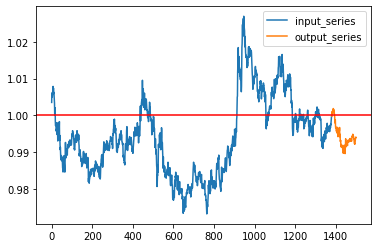

In [ ]:
idx = 0
plot_series(test_x_array[idx, :, 1], ensemble_pred_array_[idx, :])

### 3) submission df 생성하기
* 앙상블 전에 각 모델들의 buy quantity와 비교한다.
* csv 파일 형태로 제출 파일을 저장한다. 

In [ ]:
arima_test_submission = array_to_submission(test_x_array, arima_test_pred_array)
arima_test_submission.buy_quantity.value_counts()

0    402
1    127
Name: buy_quantity, dtype: int64

In [ ]:
fb_test_submission = array_to_submission(test_x_array, fb_test_pred_array)
fb_test_submission.buy_quantity.value_counts()

0    470
1     59
Name: buy_quantity, dtype: int64

In [ ]:
neu_test_submission = array_to_submission(test_x_array, neu_test_pred_array)
neu_test_submission.buy_quantity.value_counts()

((530, 3), 2)

In [ ]:
ensemble_submission = array_to_submission(test_x_array, ensemble_pred_array)
ensemble_submission.buy_quantity.value_counts() # 5%

In [ ]:
# csv로 저장
emsemble_submission.to_csv(data_path+"/Ensemble_Arima+Fb+Neuralprophet_{}.csv".format(time.strftime('%H%M')), index = False)